In [1]:
import chess
from IPython.display import display, clear_output
import random
import time

def who(player):
    return "White" if player == chess.WHITE else "Black"

class ChessGame:
    """
    Base class where the chess game is played
    """
    
    def __init__(self, player1, player2):
        self.board = chess.Board()
        
        # Setting up the players
        self.white = player1
        self.black = player2
        self.white.board = self.board
        self.black.board = self.board
        self.white.my_color = chess.WHITE
        self.black.my_color = chess.BLACK
        
        # Game outcome
        self.winner = None
        self.over = False
        
        
    def white_move(self):
        """
        White makes a move according to their best move/model
        """
        assert self.board.turn == chess.WHITE
        self.white.get_move()

        
    def black_move(self):
        """
        Black makes a move according to their best move/model
        
        :param str action: black move (must be in UCI notation)
        """
        assert self.board.turn == chess.BLACK
        self.black.get_move()
        
    def display_board(self, use_svg = 1):
        """
        Method for use in iPython Notebook to visualize board
        """
        
        display(self.board)
        
    def play_game(self, pause=0.1, display = False):
        """
        Game play by the two agents comprising the game.
        
        :param float pause: how long to pause between displays (seconds)
        :param bool display: display the board after each move, verbose output
        """
        
        try:
            while not self.board.is_game_over(claim_draw=True):
                if self.board.turn == chess.WHITE:
                    self.white_move()
                else:
                    self.black_move()
                if display:
                    self.display_board()
                    time.sleep(pause)
                    clear_output(wait=True)
                    
                    
        except KeyboardInterrupt:
            msg = "Game interrupted!"
            return (None, msg)
        result = None
        if self.board.is_checkmate():
            msg = "checkmate: " + who(not self.board.turn) + " wins!"
            result = not self.board.turn
        elif self.board.is_stalemate():
            msg = "draw: stalemate"
        elif self.board.is_fivefold_repetition():
            msg = "draw: 5-fold repetition"
        elif self.board.is_insufficient_material():
            msg = "draw: insufficient material"
        elif self.board.can_claim_draw():
            msg = "draw: claim"
        if display:
            print(msg)
        return (result, msg)
        
        
class HumanPlayer:
    """
    A human player can provide input to which move to take.
    """
    
    def __init__(self, notation = "UCI"):
        self.notation = notation
        self.board = None
        self.my_color = None
    
    def get_move(self):
        """
        User inputs move, must be a legal move in correct format.
        User gets 4 tries
        """
        for x in range(0, 4):  
            try:
                move = input("Please provide your move in %s notation (qqq to exit):" %self.notation)
                if move == "qqq":
                    raise KeyboardInterrupt
                if self.notation == "SAN":
                    self.board.push_san(move)
                else:
                    self.board.push_uci(move)
                return (move)
            except KeyboardInterrupt:
                raise KeyboardInterrupt
            except ValueError:
                pass
                
        
        
    
class RandomPlayer:
    """
    Implements a random player that picks a random move 
    out of all possible moves.
    """
    def __init__(self):
        self.board = None
        self.my_color = None
    
    def get_move(self):
        move = random.choice(list(self.board.legal_moves))
        self.board.push(move)
        
class PieceValuePlayer:
    """
    Implements a player that selects the move that will maximize 
    their piece values on the board.
    
    The only improvement over a random player is that a PieceValuePlayer
    will capture a piece if they can.
    """
    def __init__(self):
        self.board = None
        self.my_color = None
    
    def get_move(self):
        move = self.pick_highest_value_move()
        self.board.push(move)
        
    def pick_highest_value_move(self):
        """
        For each move, evaluate the position after the move,
        then select the highest value move
        """
        # Evaluate move
        moves = list(self.board.legal_moves)
        for move in moves:
            hypothetical_board = self.board.copy()
            move.score = self.static_analysis(move, hypothetical_board, self.board.turn)

        # Select random move among the moves that do best
        best_move_score = max([move.score for move in moves])
        best_moves = [move for move in moves if move.score == best_move_score]
        random_best_move = random.choice(best_moves)
        return random_best_move
    
        
    def static_analysis(self, move, board, my_color):
        """
        Evaluate the board position according to point values 
        purely based on the pieces on the board
        
        Piece values are:
            Pawn: 1
            Bishop: 4
            Queen: 10
            Knight: 3
            Rook: 5
            
        :param chess.Move move: move to evaluate
        :param chess.Board board: board on which to evaluate move
        :param bool my_color: perspective with which to evaluate moves
        """
        board.push(move)
        score = 0
        for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 3),
                           (chess.ROOK, 5)]:
            score += len(board.pieces(piece, my_color)) * value
            score -= len(board.pieces(piece, not my_color)) * value
        score += 100 if board.is_checkmate() else 0
        return score
    
class MinimaxPlayer:
    """
    Implements a player that expands the game tree up to a certain depth
    and selects the minimax move.
    
    The minimax move is the best case scenario assuming the a worst case 
    opponent. Assuming the opponent is as strong as possible and will respond 
    with their best move, we select the move that will maximize our payoff
    in this worst case scenario.
    """
    def __init__(self, depth = 2):
        """
        Class constructor for minimax player.
        
        
        """
        self.board = None
        self.max_depth = depth
        self.my_color = None
    
    def get_move(self):
        move = self.minimax(self.max_depth)
        self.board.push(move)
        
    def pick_highest_value_move_depth_2(self):
        moves = list(self.board.legal_moves)
        for move in moves:
            print ("Considering move", move)
            self.board.push(move)
            opponent_moves = list(self.board.legal_moves)
            next_moves = [self.static_analysis(move, self.board, self.board.turn) for move in opponent_moves]
            minimax = -max(next_moves)
            move.score = minimax
            self.board.pop()


        best_move_score = max([move.score for move in moves])
        best_moves = [move for move in moves if move.score == best_move_score]
        random_best_move = random.choice(best_moves)
        return random_best_move
    
    def minimax(self, depth, simulate_opponent = False):
        """
        Recursive function that expands every 
        """
        moves = list(self.board.legal_moves) 
        # If no more legal moves, then game has ended
        if len(moves) == 0:
            moves = None
            print (self.board.result)
            return self.static_analysis(None, self.board, self.my_color)
            
        # At leaf node, evaluate board position
        if depth == 1: 
            leaf_scores = [self.static_analysis(move, self.board, self.my_color) for move in moves]
            if simulate_opponent:
                return min(leaf_scores)
            else:
                return max(leaf_scores)
        
        # If simulating opponent, opponent tries to minimize my score
        if simulate_opponent:
            for move in moves:
                self.board.push(move)
                move.score = self.minimax(depth - 1, simulate_opponent = not simulate_opponent) 
                #the better the opponent scores, the worse we score
                self.board.pop()
            return min([move.score for move in moves])
        else:
        # If simulating my moves, I try to maximize my own score
            for move in moves:
                self.board.push(move)
                move.score = self.minimax(depth - 1, simulate_opponent = not simulate_opponent) 
                print ("Move:", self.board.uci(move), "score", move.score)
                #the better the opponent scores, the worse we score
                self.board.pop()
            if depth < self.max_depth:
                return max([move.score for move in moves])

        best_move_score = max([move.score for move in moves])
        best_moves = [move for move in moves if move.score == best_move_score]
        random_best_move = random.choice(best_moves)
        return random_best_move
    
        
    def static_analysis(self, move, board, my_color):
        """
        Evaluate the board position according to point values previously
        described
        
        Piece values are:
            Pawn: 1
            Bishop: 4
            Queen: 10
            Knight: 3
            Rook: 5
        """
        # Return score if the game has ended
        if move == None:
            if board.result == "1-0":
                score = 100 if my_color == 1 else -100
            elif board.result == "0-1":
                score = -100 if my_color == 1 else 100
            else:
                score = 0 
            return score
        else:
            score = 0
                
        board.push(move)
        
        for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 3),
                           (chess.ROOK, 5)]:
            score += len(board.pieces(piece, my_color)) * value
            score -= len(board.pieces(piece, not my_color)) * value
        score += 100 if board.is_checkmate() else 0
        board.pop()
        return score
    


In [11]:
import numpy as np

class AlphaBetaPlayer:
    """
    Implements a player that expands the game tree up to a certain depth,
    prunes the tree according to the alpha-beta pruning algorith,
    and selects the minimax move.
    
    The minimax move is the best case scenario assuming the a worst case 
    opponent. Assuming the opponent is as strong as possible and will respond 
    with their best move, we select the move that will maximize our payoff
    in this worst case scenario.
    
    The alpha-beta pruning algorithm avoids searching through nodes that 
    are guaranteed to violate the assumption that the opponent is as 
    strong as possible, allowing a more in-depth search.
    """
    def __init__(self, depth = 2):
        """
        Class constructor for minimax player.
        
        
        """
        self.board = None
        self.max_depth = depth
        self.my_color = None
    
    def get_move(self):
        move = self.alphabeta(move = 0, depth = self.max_depth)
        self.board.push(move)
    
    def alphabeta(self, move, depth, simulate_opponent = False, 
                alpha = -np.inf, beta = np.inf):
        """
        Recursive function that expands the minimax game tree and prunes
        it according to the alpha-beta pruning algorithm
        """
        # Documentation
        print ("Considering move", move, "alpha", alpha, "beta", beta, "simulate_opponent", simulate_opponent
              , "depth", depth)
        # At leaf node, evaluate board position
        if depth == 0: 
            return self.static_analysis(move, self.board, self.my_color) 
        
        moves = list(self.board.legal_moves) 
        # If no more legal moves, then game has ended
        if len(moves) == 0:
            moves = None
            print (self.board.result)
            return self.static_analysis(None, self.board, self.my_color)
            
        # If simulating opponent, opponent tries to minimize my score
        if 1:
            if simulate_opponent:
                best_move_score = np.inf
                for move in moves:
                    self.board.push(move)
                    move.score = self.alphabeta(move, depth - 1, not simulate_opponent,
                                             alpha, beta) 
                    self.board.pop()
                    best_move_score = min(best_move_score, move.score)
                    beta = min(beta, best_move_score)
                    #the better the opponent scores, the worse we score
                    if beta <= alpha:
                        print ("Breaking in Move:", self.board.uci(move), "score", move.score,
                               "alpha", alpha, "beta", beta,
                              "simulate_opponent", simulate_opponent, "depth", depth)
                        break
                return best_move_score
            else:
            # If simulating my moves, I try to maximize my own score
                best_move_score = -np.inf
                for move in moves:
                    self.board.push(move)
                    move.score = self.alphabeta(move, depth - 1, not simulate_opponent,
                                             alpha, beta) 
                    self.board.pop()
                    best_move_score = max(best_move_score, move.score)
                    alpha = max(alpha, best_move_score)
                    if depth == self.max_depth:
                        print ("Move:", self.board.uci(move), "score", move.score)
                    if beta <= alpha:
                        print ("Breaking in Move:", self.board.uci(move), "score", move.score,
                               "alpha", alpha, "beta", beta,
                              "simulate_opponent", simulate_opponent, "depth", depth)
                        break

                if depth < self.max_depth:
                    return best_move_score

        else:
            if simulate_opponent:
                best_move_score = np.inf
                for move in moves:
                    self.board.push(move)
                    move.score = self.alphabeta(move, depth - 1, not simulate_opponent,
                                             alpha, beta) 
                    self.board.pop()
                    best_move_score = max(best_move_score, move.score)
                    alpha = max(alpha, best_move_score)
                    #the better the opponent scores, the worse we score
                    if beta <= alpha:
                        print ("Breaking in Move:", self.board.uci(move), "score", move.score,
                               "alpha", alpha, "beta", beta,
                              "simulate_opponent", simulate_opponent, "depth", depth)
                        break
                return best_move_score
            else:
            # If simulating my moves, I try to maximize my own score
                best_move_score = -np.inf
                for move in moves:
                    self.board.push(move)
                    move.score = self.alphabeta(move, depth - 1, not simulate_opponent,
                                             alpha, beta) 
                    self.board.pop()
                    best_move_score = min(best_move_score, move.score)
                    beta = min(beta, best_move_score)
                    if depth == self.max_depth:
                        print ("Move:", self.board.uci(move), "score", move.score)
                    if beta <= alpha:
                        break

                if depth < self.max_depth:
                    return best_move_score

        best_move_score = max([move.score for move in moves])
            
        best_moves = [move for move in moves if move.score == best_move_score]
        random_best_move = random.choice(best_moves)
        print ("Returning move", random_best_move)
        return random_best_move
    
        
    def static_analysis(self, move, board, my_color):
        """
        Evaluate the board position according to point values previously
        described
        
        Piece values are:
            Pawn: 1
            Bishop: 4
            Queen: 10
            Knight: 3
            Rook: 5
        """
        # Return score if the game has ended
        if move == None:
            if board.result == "1-0":
                score = 100 if my_color == 1 else -100
            elif board.result == "0-1":
                score = -100 if my_color == 1 else 100
            else:
                score = 0 
            return score
        else:
            score = 0
                
        board.push(move)
        
        for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 3),
                           (chess.ROOK, 5)]:
            score += len(board.pieces(piece, my_color)) * value
            score -= len(board.pieces(piece, not my_color)) * value
        score += 100 if board.is_checkmate() else 0
        board.pop()
        return score
    


Considering move 0 alpha -inf beta inf simulate_opponent False depth 2
Considering move g4c8 alpha -inf beta inf simulate_opponent True depth 1
Considering move g8e7 alpha -inf beta inf simulate_opponent False depth 0
Considering move g8h6 alpha -inf beta 4 simulate_opponent False depth 0
Considering move f8e7 alpha -inf beta 4 simulate_opponent False depth 0
Considering move f8d6 alpha -inf beta 4 simulate_opponent False depth 0
Considering move f8c5 alpha -inf beta 4 simulate_opponent False depth 0
Considering move f8b4 alpha -inf beta 4 simulate_opponent False depth 0
Considering move f8a3 alpha -inf beta 4 simulate_opponent False depth 0
Considering move e8f7 alpha -inf beta 4 simulate_opponent False depth 0
Considering move e8e7 alpha -inf beta 4 simulate_opponent False depth 0
Considering move d8c8 alpha -inf beta 4 simulate_opponent False depth 0
Considering move b8d7 alpha -inf beta -6 simulate_opponent False depth 0
Considering move b8c6 alpha -inf beta -6 simulate_opponent Fa

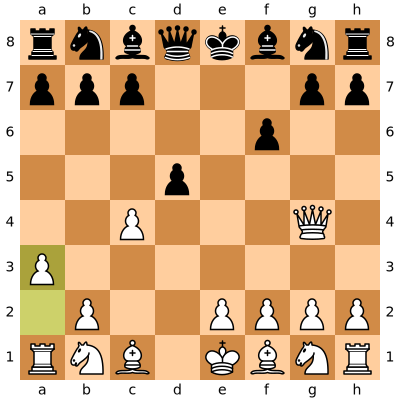

In [ ]:
tic = time.time()
game = ChessGame(AlphaBetaPlayer(depth = 2), HumanPlayer("SAN"))
res, msg = game.play_game(display = 1, pause = 2)
toc = time.time()
print (toc-tic)



print (res, msg, game.board.fullmove_number)

In [ ]:
game.board.fen()

In [ ]:
board.push_uci("e2e4")

In [ ]:
board.push_uci("e7e5")

In [ ]:
board.result()

In [ ]:
board